# Wokflow  con zLGBM

1. voy a sacar las variables 'misteriosas' y ejecutar todo tal como estaba
2. ahora cambio drifting inflacionaro, de ranking cero fijo a IPC

comp3

PARAM$experimento <- "z-30901" 
Activo todas las tendencias
tuve que corregir los meses de tendencia (02 a 07)

ksemillerio = 50
plocal$min_data_in_leaf <- 500L
$undersampling <- 0.20  
num_iterations= 128

future(202109)



## Inicializacion

In [1]:
# limpio la memoria
Sys.time()
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

[1] "2025-12-03 17:10:03 UTC"

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,658628,35.2,1454708,77.7,1235609,66.0
Vcells,1222601,9.4,8388608,64.0,1975163,15.1


In [2]:
plocal <- list()

# 501
plocal$qcanaritos <- 5L
plocal$min_data_in_leaf <- 500L
plocal$learning_rate <- 1.0
plocal$gradient_bound <- 0.1


plocal$APO <- 1
plocal$ksemillerio <- 50


In [3]:
PARAM <- list()
PARAM$experimento <- "z-30901"
PARAM$semilla_primigenia <- 991027

In [4]:
setwd("/content/buckets/b1/exp")
experimento_folder <- PARAM$experimento
dir.create(experimento_folder, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento_folder ))

## Preprocesamiento

### Generacion de la clase_ternaria

In [5]:
Sys.time()
require( "data.table" )

# leo el dataset
dataset_1 <- fread("~/datasets/competencia_02_crudo.csv.gz" )
dataset_2 <- fread("~/datasets/competencia_03_crudo.csv.gz")
dim(dataset_1)
dim(dataset_2)

dataset <- rbindlist(list(dataset_1, dataset_2), use.names = TRUE, fill = TRUE)
dim(dataset)

# calculo el periodo0 consecutivo
dsimple <- dataset[, list(
  "pos" = .I,
  numero_de_cliente,
  periodo0 = as.integer(foto_mes/100)*12 +  foto_mes%%100 )
]


# ordeno
setorder( dsimple, numero_de_cliente, periodo0 )

# calculo topes
periodo_ultimo <- dsimple[, max(periodo0) ]
periodo_anteultimo <- periodo_ultimo - 1


# calculo los leads de orden 1 y 2
dsimple[, c("periodo1", "periodo2") :=
  shift(periodo0, n=1:2, fill=NA, type="lead"),  numero_de_cliente
]

# assign most common class values = "CONTINUA"
dsimple[ periodo0 < periodo_anteultimo, clase_ternaria := "CONTINUA" ]

# calculo BAJA+1
dsimple[ periodo0 < periodo_ultimo &
  ( is.na(periodo1) | periodo0 + 1 < periodo1 ),
  clase_ternaria := "BAJA+1"
]

# calculo BAJA+2
dsimple[ periodo0 < periodo_anteultimo & (periodo0+1 == periodo1 )
  & ( is.na(periodo2) | periodo0 + 2 < periodo2 ),
  clase_ternaria := "BAJA+2"
]

# pego el resultado en el dataset original y grabo
setorder( dsimple, pos )
dataset[, clase_ternaria := dsimple$clase_ternaria ]

rm(dsimple)
gc()
Sys.time()

[1] "2025-12-03 17:10:03 UTC"

Loading required package: data.table



[1] 4717958     154

[1] 165093    154

[1] 4883051     154

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,769490,41.1,1454708,77.7,1454708,77.7
Vcells,1301337300,9928.5,1777928945,13564.6,1449767260,11060.9


[1] "2025-12-03 17:10:33 UTC"

In [6]:
setorder( dataset, foto_mes, clase_ternaria, numero_de_cliente)
dataset[, .N, list(foto_mes, clase_ternaria)]

foto_mes,clase_ternaria,N
<int>,<chr>,<int>
201901,BAJA+1,645
201901,BAJA+2,729
201901,CONTINUA,122899
201902,BAJA+1,733
201902,BAJA+2,707
201902,CONTINUA,123961
201903,BAJA+1,708
201903,BAJA+2,751
201903,CONTINUA,124508


### Eliminacion de Features

Completar a gusto LUEGO de realizar un analisis exploratorio de datos.
<br> No necesariamente en esta Segunda Competencia conviele eliminar los mismos campos que en la Primera ...

In [7]:
# Salsa Magica para 202106
dataset[, mprestamos_personales := NULL ]
dataset[, cprestamos_personales := NULL ]

In [8]:
#Elimino los campos problematicos #####
#Internet rota dde de 202010
dataset[  , internet := NULL ]

#Internet rota dde de 202010
dataset[  , tmobile_app := NULL ]

# cmobile rota dde 202010                 MIO
dataset[  , cmobile_app_trx := NULL ]

### Reemplazar 0

In [9]:
# 1) Seleccionar columnas numéricas foto_mes'
cols_num <- names(dataset)[vapply(dataset, is.numeric, logical(1L))]
cols_num <- setdiff(cols_num, "foto_mes")


# 2) Detección: para cada mes y columna, TRUE si todos los no-NA son 0 y hay al menos un no-NA
todo_cero_por_mes <- dataset[
  , lapply(.SD, function(x) {
    n_no_na <- sum(!is.na(x))
    (n_no_na == .N) && (max(x, na.rm = TRUE) == 0) && (min(x, na.rm = TRUE) == 0)
  }),
  by = foto_mes,
  .SDcols = cols_num
]

# 3) Pasar a formato largo y quedarnos con las parejas dañadas
danados_long <- melt(
  todo_cero_por_mes,
  id.vars   = "foto_mes",
  variable.name = "atributo",
  value.name    = "todo_cero"
)[todo_cero == TRUE][, todo_cero := NULL]

# a) Cuántos atributos dañados tiene cada mes
resumen_por_mes <- danados_long[, .N, by = foto_mes][order(foto_mes)]

# b) Para cada atributo, en qué meses está dañado
resumen_por_atributo <- danados_long[, .(meses_danados = paste(sort(foto_mes), collapse = ", ")), by = atributo][order(atributo)]

# 4) Reemplazar 0 con NA solo en esas parejas <atributo, foto_mes>
for (col in unique(danados_long$atributo)) {
  meses <- danados_long[atributo == col, foto_mes]
  
  # índices de filas del/los mes/es afectados donde la columna vale 0
  idx <- which(dataset$foto_mes %in% meses & dataset[[col]] == 0)
  
  # elegir NA del tipo correcto
  val_NA <- if (is.integer(dataset[[col]])) NA_integer_ else NA_real_
  
  # asignación por referencia, sin copiar
  set(dataset, i = idx, j = col, value = val_NA)
}


### Feature Engineering Intra-Mes

Crear variables nuevas a partir de las existentes dentro del mismo registro, **sin** ir a buscar información histórica.
<br> El siguiente código es un mínimo ejemplo, agregar nuevos features a gusto

In [10]:
# el mes 1,2, ..12 , podria servir para detectar estacionalidad
dataset[, kmes := foto_mes %% 100]

# creo un ctr_quarter que tenga en cuenta cuando
# los clientes hace 3 menos meses que estan
# ya que seria injusto considerar las transacciones medidas en menor tiempo
dataset[, ctrx_quarter_normalizado := as.numeric(ctrx_quarter) ]
dataset[cliente_antiguedad == 1, ctrx_quarter_normalizado := ctrx_quarter * 5.0]
dataset[cliente_antiguedad == 2, ctrx_quarter_normalizado := ctrx_quarter * 2.0]
dataset[cliente_antiguedad == 3, ctrx_quarter_normalizado := ctrx_quarter * 1.2]

# variable extraida de una tesis de maestria de Irlanda, se perdió el link
dataset[, mpayroll_sobre_edad := mpayroll / cliente_edad]

Sys.time()

[1] "2025-12-03 17:10:45 UTC"

In [11]:
# ### NUEVO ################
# setorder(dataset, numero_de_cliente, foto_mes)

# # 1) Antigüedad en meses desde el primer registro
# dataset[, cliente_antiguedad_orden := seq_len(.N),
#         by = numero_de_cliente]

# # 2) Percentil de antigüedad dentro de cada mes
# dataset[, cliente_antiguedad_percentil_mes :=
#           frank(cliente_antiguedad_orden, ties.method = "average") / .N,
#         by = foto_mes]

# # 3) Distribución acumulada de antigüedad
# dataset[, cliente_antiguedad_distri_acum :=
#           frank(cliente_antiguedad_orden, ties.method = "max") / .N,
#         by = foto_mes]

# # 4) Cuartil (1–4)
# dataset[, cliente_antiguedad_cuartil :=
#           as.integer(ceiling(
#             frank(cliente_antiguedad_orden, ties.method = "average") / .N * 4L)),
#         by = foto_mes]

# # 5) Decil (1–10)
# dataset[, cliente_antiguedad_decil :=
#           as.integer(ceiling(
#             frank(cliente_antiguedad_orden, ties.method = "average") / .N * 10L)),
#         by = foto_mes]

### Data drifting

In [12]:
# ordeno para hacer ranking 
# SOLO VARS MONETARIAS 
# setorder( dataset, foto_mes, numero_de_cliente )

# # identificar variables monetarias (empiezan con m|Visa_m|Master_m)
# campos_monetarios  <- colnames(dataset)
# campos_monetarios  <- campos_monetarios[campos_monetarios %like% "^(m|Visa_m|Master_m|vm_m)"]

# set.seed(PARAM$semilla_primigenia)  # para reproducibilidad del ties.method="random"

# drift_rank_cero_fijo  <- function( campos_drift ) {
#   for( campo in campos_drift ) {
#     cat(campo, " ")
#     dataset[get(campo) == 0, paste0(campo,"_rank") := 0]
#     dataset[get(campo) > 0, paste0(campo,"_rank") :=
#               frank(get(campo), ties.method="random") / .N,
#             by = foto_mes]
#     dataset[get(campo) < 0, paste0(campo,"_rank") :=
#               -frank(-get(campo), ties.method="random") / .N,
#             by = foto_mes]
#     dataset[ , (campo) := NULL ]
#   }
# }

# # Aplico ranking de cero fijo
# drift_rank_cero_fijo(campos_monetarios)


In [13]:
# # Control de drifting mediante IPC con mes base 202001 (arbitrariamente). Pesos constantes.

# # identificar campos monetarios
# campos_monetarios  <- colnames(dataset)
# campos_monetarios  <- campos_monetarios[campos_monetarios %like% "^(m|Visa_m|Master_m)"]

# # 1) Definís los meses y el IPC (base 202001 = 1)
# vfoto_mes <- c(
#   201901, 201902, 201903, 201904, 201905, 201906,
#   201907, 201908, 201909, 201910, 201911, 201912,
#   202001, 202002, 202003, 202004, 202005, 202006,
#   202007, 202008, 202009, 202010, 202011, 202012,
#   202101, 202102, 202103, 202104, 202105, 202106,
#   202107
# )

# vIPC_base_202001 <- c(
#   1.514,  # 201901
#   1.458,  # 201902
#   1.391,  # 201903
#   1.348,  # 201904
#   1.309,  # 201905
#   1.275,  # 201906
#   1.249,  # 201907
#   1.202,  # 201908
#   1.136,  # 201909
#   1.101,  # 201910
#   1.058,  # 201911
#   1.019,  # 201912
#   1.000,  # 202001 (base)
#   0.982,  # 202002
#   0.949,  # 202003
#   0.935,  # 202004
#   0.922,  # 202005
#   0.904,  # 202006
#   0.889,  # 202007
#   0.865,  # 202008
#   0.842,  # 202009
#   0.812,  # 202010
#   0.789,  # 202011
#   0.760,  # 202012
#   0.736,  # 202101
#   0.710,  # 202102
#   0.675,  # 202103
#   0.649,  # 202104
#   0.628,  # 202105
#   0.609,  # 202106
#   0.590   # 202107
# )

# tb_IPC <- data.table(
#   foto_mes = vfoto_mes,
#   IPC      = vIPC_base_202001
# )

# # 3) Aplicar la transformación a pesos constantes (join + multiplicación)
# dataset[
#   tb_IPC,
#   on = "foto_mes",
#   (campos_monetarios) := .SD * i.IPC,
#   .SDcols = campos_monetarios
# ]

In [14]:
campos_monetarios  <- colnames(dataset)
campos_monetarios  <- campos_monetarios[campos_monetarios %like% "^(m|Visa_m|Master_m)"]

In [15]:
campos_monetarios

[1] "mrentabilidad"                       
 [2] "mrentabilidad_annual"                
 [3] "mcomisiones"                         
 [4] "mactivos_margen"                     
 [5] "mpasivos_margen"                     
 [6] "mcuenta_corriente_adicional"         
 [7] "mcuenta_corriente"                   
 [8] "mcaja_ahorro"                        
 [9] "mcaja_ahorro_adicional"              
[10] "mcaja_ahorro_dolares"                
[11] "mcuentas_saldo"                      
[12] "mautoservicio"                       
[13] "mtarjeta_visa_consumo"               
[14] "mtarjeta_master_consumo"             
[15] "mprestamos_prendarios"               
[16] "mprestamos_hipotecarios"             
[17] "mplazo_fijo_dolares"                 
[18] "mplazo_fijo_pesos"                   
[19] "minversion1_pesos"                   
[20] "minversion1_dolares"                 
[21] "minversion2"                         
[22] "mpayroll"                            
[23] "mpayroll2"                           
[24] "mcuenta_debitos_automaticos"         
[25] "mttarjeta_visa_debitos_automaticos"  
[26] "mttarjeta_master_debitos_automaticos"
[27] "mpagodeservicios"                    
[28] "mpagomiscuentas"                     
[29] "mcajeros_propios_descuentos"         
[30] "mtarjeta_visa_descuentos"            
[31] "mtarjeta_master_descuentos"          
[32] "mcomisiones_mantenimiento"           
[33] "mcomisiones_otras"                   
[34] "mforex_buy"                          
[35] "mforex_sell"                         
[36] "mtransferencias_recibidas"           
[37] "mtransferencias_emitidas"            
[38] "mextraccion_autoservicio"            
[39] "mcheques_depositados"                
[40] "mcheques_emitidos"                   
[41] "mcheques_depositados_rechazados"     
[42] "mcheques_emitidos_rechazados"        
[43] "matm"                                
[44] "matm_other"                          
[45] "Master_mfinanciacion_limite"         
[46] "Master_msaldototal"                  
[47] "Master_msaldopesos"                  
[48] "Master_msaldodolares"                
[49] "Master_mconsumospesos"               
[50] "Master_mconsumosdolares"             
[51] "Master_mlimitecompra"                
[52] "Master_madelantopesos"               
[53] "Master_madelantodolares"             
[54] "Master_mpagado"                      
[55] "Master_mpagospesos"                  
[56] "Master_mpagosdolares"                
[57] "Master_mconsumototal"                
[58] "Master_mpagominimo"                  
[59] "Visa_mfinanciacion_limite"           
[60] "Visa_msaldototal"                    
[61] "Visa_msaldopesos"                    
[62] "Visa_msaldodolares"                  
[63] "Visa_mconsumospesos"                 
[64] "Visa_mconsumosdolares"               
[65] "Visa_mlimitecompra"                  
[66] "Visa_madelantopesos"                 
[67] "Visa_madelantodolares"               
[68] "Visa_mpagado"                        
[69] "Visa_mpagospesos"                    
[70] "Visa_mpagosdolares"                  
[71] "Visa_mconsumototal"                  
[72] "Visa_mpagominimo"                    
[73] "mpayroll_sobre_edad"

In [16]:
# funcion rescatada de https://github.com/mcnanton/labo/blob/main/src/entrega_competencia_3/z925_FE_historia.r
# mes base: 202012
drift_deflacion  <- function( campos_monetarios )
{
  vfoto_mes <- c( 201901, 201902, 201903, 201904, 201905, 201906,
                  201907, 201908, 201909, 201910, 201911, 201912,
                  202001, 202002, 202003, 202004, 202005, 202006,
                  202007, 202008, 202009, 202010, 202011, 202012,
                  202101, 202102, 202103, 202104, 202105, 202106,
                  202107, 202108, 202109 )

        # valores validados con: https://www.indec.gob.ar/indec/web/Nivel4-Tema-3-5-31
  vIPC  <- c( 1.9903030878, 1.9174403544, 1.8296186587,
              1.7728862972, 1.7212488323, 1.6776304408,
              1.6431248196, 1.5814483345, 1.4947526791,
              1.4484037589, 1.3913580777, 1.3404220402,
              1.3154288912, 1.2921698342, 1.2472681797,
              1.2300475145, 1.2118694724, 1.1881073259,
              1.1693969743, 1.1375456949, 1.1065619600,
              1.0681100000, 1.0370000000, 1.0000000000,
              0.9680542110, 0.9344152616, 0.8882274350,
              0.8532444140, 0.8251880213, 0.8003763543,
              0.7763107219, 0.7573763140, 0.7313394447 )

  tb_IPC  <- data.table( "foto_mes"= vfoto_mes,
                         "IPC" = vIPC )

  dataset[ tb_IPC,
           on= c("foto_mes"),
           (campos_monetarios) :=  .SD * i.IPC ,
           .SDcols = campos_monetarios ]

}

drift_deflacion(campos_monetarios)


In [17]:
setorder( dataset, foto_mes, numero_de_cliente )
head(dataset)

numero_de_cliente,foto_mes,active_quarter,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,⋯,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,clase_ternaria,kmes,ctrx_quarter_normalizado,mpayroll_sobre_edad
<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<int>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
249221323,201901,1,0,44,69,171.8229,29078.35,1245.6312,-649.87376,⋯,0.000,2083,9.714530e+03,5,0,24326.7979,CONTINUA,1,95,2231.159
249227600,201901,1,0,40,254,4171.7947,31656.59,572.6301,552.24940,⋯,0.000,4810,1.343612e+04,11,0,1120.6203,CONTINUA,1,132,3549.128
249227813,201901,1,0,77,156,2131.7539,20490.35,1720.4180,-62.95329,⋯,0.000,4739,2.786424e-01,2,0,303.5013,CONTINUA,1,25,0.000
249231391,201901,1,0,55,252,1950.4572,15266.58,969.2975,-2223.30787,⋯,0.000,4344,2.508614e+04,13,0,3408.5533,CONTINUA,1,117,1887.752
249244739,201901,1,0,64,296,5422.9191,72099.37,3713.6866,-7146.95945,⋯,0.000,1227,4.066906e+03,3,0,933.8502,CONTINUA,1,173,0.000
249255456,201901,1,0,62,296,28464.1604,87568.18,17854.6507,-2512.20036,⋯,2079.907,5604,2.429323e+05,50,0,22272.3275,CONTINUA,1,174,3523.778


### Feature Engineering Historico

In [18]:
if( !require("Rcpp")) install.packages("Rcpp", repos = "http://cran.us.r-project.org")
require("Rcpp")

Loading required package: Rcpp



In [19]:
# se calculan para los 6 meses previos el minimo, maximo y
#  tendencia calculada con cuadrados minimos
# la formula de calculo de la tendencia puede verse en
#  https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/10%3A_Correlation_and_Regression/10.04%3A_The_Least_Squares_Regression_Line
# para la maxíma velocidad esta funcion esta escrita en lenguaje C,
# y no en la porqueria de R o Python

cppFunction("NumericVector fhistC(NumericVector pcolumna, IntegerVector pdesde )
{
  /* Aqui se cargan los valores para la regresion */
  double  x[100] ;
  double  y[100] ;

  int n = pcolumna.size();
  NumericVector out( 5*n );

  for(int i = 0; i < n; i++)
  {
    //lag
    if( pdesde[i]-1 < i )  out[ i + 4*n ]  =  pcolumna[i-1] ;
    else                   out[ i + 4*n ]  =  NA_REAL ;


    int  libre    = 0 ;
    int  xvalor   = 1 ;

    for( int j= pdesde[i]-1;  j<=i; j++ )
    {
       double a = pcolumna[j] ;

       if( !R_IsNA( a ) )
       {
          y[ libre ]= a ;
          x[ libre ]= xvalor ;
          libre++ ;
       }

       xvalor++ ;
    }

    /* Si hay al menos dos valores */
    if( libre > 1 )
    {
      double  xsum  = x[0] ;
      double  ysum  = y[0] ;
      double  xysum = xsum * ysum ;
      double  xxsum = xsum * xsum ;
      double  vmin  = y[0] ;
      double  vmax  = y[0] ;

      for( int h=1; h<libre; h++)
      {
        xsum  += x[h] ;
        ysum  += y[h] ;
        xysum += x[h]*y[h] ;
        xxsum += x[h]*x[h] ;

        if( y[h] < vmin )  vmin = y[h] ;
        if( y[h] > vmax )  vmax = y[h] ;
      }

      out[ i ]  =  (libre*xysum - xsum*ysum)/(libre*xxsum -xsum*xsum) ;
      out[ i + n ]    =  vmin ;
      out[ i + 2*n ]  =  vmax ;
      out[ i + 3*n ]  =  ysum / libre ;
    }
    else
    {
      out[ i       ]  =  NA_REAL ;
      out[ i + n   ]  =  NA_REAL ;
      out[ i + 2*n ]  =  NA_REAL ;
      out[ i + 3*n ]  =  NA_REAL ;
    }
  }

  return  out;
}")

In [20]:
# calcula la tendencia de las variables cols de los ultimos 6 meses
# la tendencia es la pendiente de la recta que ajusta por cuadrados minimos
# La funcionalidad de ratioavg es autoria de  Daiana Sparta,  UAustral  2021

TendenciaYmuchomas <- function(
    dataset, cols, ventana = 6, tendencia = TRUE,
    minimo = TRUE, maximo = TRUE, promedio = TRUE,
    ratioavg = FALSE, ratiomax = FALSE) {
  gc(verbose= FALSE)
  # Esta es la cantidad de meses que utilizo para la historia
  ventana_regresion <- ventana

  last <- nrow(dataset)

  # creo el vector_desde que indica cada ventana
  # de esta forma se acelera el procesamiento ya que lo hago una sola vez
  vector_ids <- dataset[ , numero_de_cliente ]

  vector_desde <- seq(
    -ventana_regresion + 2,
    nrow(dataset) - ventana_regresion + 1
  )

  vector_desde[1:ventana_regresion] <- 1

  for (i in 2:last) {
    if (vector_ids[i - 1] != vector_ids[i]) {
      vector_desde[i] <- i
    }
  }
  for (i in 2:last) {
    if (vector_desde[i] < vector_desde[i - 1]) {
      vector_desde[i] <- vector_desde[i - 1]
    }
  }

  for (campo in cols) {
    nueva_col <- fhistC(dataset[, get(campo)], vector_desde)

    if (tendencia) {
      dataset[, paste0(campo, "_tend", ventana) :=
        nueva_col[(0 * last + 1):(1 * last)]]
    }

    if (minimo) {
      dataset[, paste0(campo, "_min", ventana) :=
        nueva_col[(1 * last + 1):(2 * last)]]
    }

    if (maximo) {
      dataset[, paste0(campo, "_max", ventana) :=
        nueva_col[(2 * last + 1):(3 * last)]]
    }

    if (promedio) {
      dataset[, paste0(campo, "_avg", ventana) :=
        nueva_col[(3 * last + 1):(4 * last)]]
    }

    if (ratioavg) {
      dataset[, paste0(campo, "_ratioavg", ventana) :=
        get(campo) / nueva_col[(3 * last + 1):(4 * last)]]
    }

    if (ratiomax) {
      dataset[, paste0(campo, "_ratiomax", ventana) :=
        get(campo) / nueva_col[(2 * last + 1):(3 * last)]]
    }
  }
}

#### Lags y delta lags

In [21]:
# Feature Engineering Historico
# Creacion de LAGs
setorder(dataset, numero_de_cliente, foto_mes)

# todo es lagueable, menos la primary key y la clase
cols_lagueables <- copy( setdiff(
  colnames(dataset),
  c("numero_de_cliente", "foto_mes", "clase_ternaria")
))

# https://rdrr.io/cran/data.table/man/shift.html

# lags de orden 1
dataset[,
  paste0(cols_lagueables, "_lag1") := shift(.SD, 1, NA, "lag"),
  by= numero_de_cliente,
  .SDcols= cols_lagueables
]

# lags de orden 2
dataset[,
  paste0(cols_lagueables, "_lag2") := shift(.SD, 2, NA, "lag"),
  by= numero_de_cliente,
  .SDcols= cols_lagueables
]

# agrego los delta lags
for (vcol in cols_lagueables)
{
  dataset[, paste0(vcol, "_delta1") := get(vcol) - get(paste0(vcol, "_lag1"))]
  dataset[, paste0(vcol, "_delta2") := get(vcol) - get(paste0(vcol, "_lag2"))]
}

Sys.time()

[1] "2025-12-03 17:13:19 UTC"

In [22]:
# # lags del diccionario
# dataset[, lag_1_ctrx_quarter := ctrx_quarter_lag1]
# dataset[, lag_2_ctrx_quarter := ctrx_quarter_lag2]

# dataset[, lag_3_ctrx_quarter :=
#           shift(ctrx_quarter, 3L, NA, "lag"),
#         by = numero_de_cliente]

# # deltas del diccionario
# dataset[, delta_1_ctrx_quarter := ctrx_quarter_delta1]
# dataset[, delta_2_ctrx_quarter := ctrx_quarter_delta2]
# dataset[, delta_3_ctrx_quarter := ctrx_quarter - lag_3_ctrx_quarter]

# # ventanas móviles
# dataset[, ctrx_quarter_media_3 :=
#           frollmean(ctrx_quarter, n = 4L, align = "right"),
#         by = numero_de_cliente]

# dataset[, ctrx_quarter_max_3 :=
#           frollapply(ctrx_quarter, n = 4L, align = "right", FUN = max),
#         by = numero_de_cliente]

# dataset[, ctrx_quarter_min_3 :=
#           frollapply(ctrx_quarter, n = 4L, align = "right", FUN = min),
#         by = numero_de_cliente]

# dataset[, crecimiento_ctrx_quarter :=
#           (ctrx_quarter - lag_1_ctrx_quarter) / lag_1_ctrx_quarter]
# dataset[!is.finite(crecimiento_ctrx_quarter),
#         crecimiento_ctrx_quarter := NA_real_]

# dataset[, volatilidad_ctrx_quarter :=
#           frollapply(ctrx_quarter, n = 3L, align = "right", FUN = sd),
#         by = numero_de_cliente]

#### Tendencias

In [23]:
# parametros de Feature Engineering Historico de Tendencias
PARAM$FE_hist$Tendencias$run <- TRUE
PARAM$FE_hist$Tendencias$ventana <- 6
PARAM$FE_hist$Tendencias$tendencia <- TRUE
PARAM$FE_hist$Tendencias$minimo <- TRUE
PARAM$FE_hist$Tendencias$maximo <- TRUE
PARAM$FE_hist$Tendencias$promedio <- TRUE
PARAM$FE_hist$Tendencias$ratioavg <- TRUE
PARAM$FE_hist$Tendencias$ratiomax <- TRUE

In [24]:
# aqui se agregan las tendencias de los ultimos 6 meses

cols_lagueables <- intersect(cols_lagueables, colnames(dataset))
setorder(dataset, numero_de_cliente, foto_mes)

if( PARAM$FE_hist$Tendencias$run) {
    TendenciaYmuchomas(dataset,
    cols = cols_lagueables,
    ventana = PARAM$FE_hist$Tendencias$ventana, # 6 meses de historia
    tendencia = PARAM$FE_hist$Tendencias$tendencia,
    minimo = PARAM$FE_hist$Tendencias$minimo,
    maximo = PARAM$FE_hist$Tendencias$maximo,
    promedio = PARAM$FE_hist$Tendencias$promedio,
    ratioavg = PARAM$FE_hist$Tendencias$ratioavg,
    ratiomax = PARAM$FE_hist$Tendencias$ratiomax
  )
}

ncol(dataset)
Sys.time()

[1] 1178

[1] "2025-12-03 17:15:35 UTC"

### Feature Engineering a partir de hojas de Random Forest ####

In [25]:
# definir funcion
if( !require("lightgbm")) install.packages("lightgbm")
require("lightgbm")

AgregaVarRandomForest <- function() {
  
  cat( "inicio AgregaVarRandomForest()\n")
  gc(verbose= FALSE)
  dataset[, clase01 := 0L ]
  dataset[ clase_ternaria %in% c( "BAJA+2", "BAJA+1"),
           clase01 := 1L ]
  
  campos_buenos <- setdiff(
    colnames(dataset),
    c( "clase_ternaria", "clase01")
  )
  
  dataset[, entrenamiento :=
            as.integer( foto_mes %in% PARAM$FE_rf$train$training )]
  
  dtrain <- lgb.Dataset(
    data = data.matrix(dataset[entrenamiento == TRUE, campos_buenos, with = FALSE]),
    label = dataset[entrenamiento == TRUE, clase01],
    free_raw_data = FALSE
  )
  
  modelo <- lgb.train(
    data = dtrain,
    param = PARAM$FE_rf$lgb_param,
    verbose = -100
  )
  
  cat( "Fin construccion RandomForest\n" )
  # grabo el modelo, achivo .model
  lgb.save(modelo, file="modelo.model" )
  
  qarbolitos <- copy(PARAM$FE_rf$lgb_param$num_iterations)
  
  periodos <- dataset[ , unique( foto_mes ) ]
  
  for( periodo in  periodos )
  {
    cat( "periodo = ", periodo, "\n" )
    datamatrix <- data.matrix(dataset[ foto_mes== periodo, campos_buenos, with = FALSE])
    
    cat( "Inicio prediccion\n" )
    prediccion <- predict(
      modelo,
      datamatrix,
      type = "leaf"
    )
    cat( "Fin prediccion\n" )
    
    for( arbolito in 1:qarbolitos )
    {
      cat( arbolito, " " )
      hojas_arbol <- unique(prediccion[ , arbolito])
      
      for (pos in 1:length(hojas_arbol)) {
        # el numero de nodo de la hoja, estan salteados
        nodo_id <- hojas_arbol[pos]
        dataset[ foto_mes== periodo, paste0(
          "rf_", sprintf("%03d", arbolito),
          "_", sprintf("%03d", nodo_id)
        ) :=  as.integer( nodo_id == prediccion[ , arbolito]) ]
        
      }
      
      rm( hojas_arbol )
    }
    cat( "\n" )
    
    rm( prediccion )
    rm( datamatrix )
    gc(verbose= FALSE)
  }
  
  gc(verbose= FALSE)
  
  # borro clase01 , no debe ensuciar el dataset
  dataset[ , clase01 := NULL ]
  
}

Loading required package: lightgbm



In [26]:
# Parametros de Feature Engineering  a partir de hojas de Random Forest

# Estos CUATRO parametros son los que se deben modificar
PARAM$FE_rf$arbolitos= 20
PARAM$FE_rf$hojas_por_arbol= 16
PARAM$FE_rf$datos_por_hoja= 100
PARAM$FE_rf$mtry_ratio= 0.2

# Estos son quasi fijos
PARAM$FE_rf$train$training <- c(202102, 202103, 202104, 202105, 202106, 202107)

# Estos TAMBIEN son quasi fijos
PARAM$FE_rf$lgb_param <-list(
  # parametros que se pueden cambiar
  num_iterations = PARAM$FE_rf$arbolitos,
  num_leaves  = PARAM$FE_rf$hojas_por_arbol,
  min_data_in_leaf = PARAM$FE_rf$datos_por_hoja,
  feature_fraction_bynode  = PARAM$FE_rf$mtry_ratio,
  
  # para que LightGBM emule Random Forest
  boosting = "rf",
  bagging_fraction = ( 1.0 - 1.0/exp(1.0) ),
  bagging_freq = 1.0,
  feature_fraction = 1.0,
  
  # genericos de LightGBM
  max_bin = 31L,
  objective = "binary",
  first_metric_only = TRUE,
  boost_from_average = TRUE,
  feature_pre_filter = FALSE,
  force_row_wise = TRUE,
  verbosity = -100,
  max_depth = -1L,
  min_gain_to_split = 0.0,
  min_sum_hessian_in_leaf = 0.001,
  lambda_l1 = 0.0,
  lambda_l2 = 0.0,
  
  pos_bagging_fraction = 1.0,
  neg_bagging_fraction = 1.0,
  is_unbalance = FALSE,
  scale_pos_weight = 1.0,
  
  drop_rate = 0.1,
  max_drop = 50,
  skip_drop = 0.5,
  
  extra_trees = FALSE
)

In [27]:
# implementar RF
AgregaVarRandomForest()

Sys.time()


inicio AgregaVarRandomForest()
Fin construccion RandomForest
periodo =  201901 
Inicio prediccion
Fin prediccion
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  
periodo =  201902 
Inicio prediccion
Fin prediccion
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  
periodo =  201903 
Inicio prediccion
Fin prediccion
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  
periodo =  201904 
Inicio prediccion
Fin prediccion
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  
periodo =  201905 
Inicio prediccion
Fin prediccion
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  
periodo =  201906 
Inicio prediccion
Fin prediccion
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  
periodo =  201907 
Inicio prediccion
Fin prediccion
1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  
periodo =  201908 
Inicio prediccion
Fin prediccion
1  2  3  4  5  6  7

[1] "2025-12-03 17:20:54 UTC"

## Modelado

No hay modelado, no se hace optimizacion de hiperparametros.

## Produccion

Las decisiones que se toman para la construccion del modelo final son:
* Los positvos son  POS={"BAJA+1", "BAJA+2"}, esta es una meticulosa decisión.
* Se entrena en los treinta meses del intervalo [201901, 202104]
* Se realiza undersampling al 5%
* Se utilizan los hiperparámetros optimos encontrados en la Bayesian Optimization
   * Se escala min_data_in_leaf

### Final Training Strategy

In [28]:
PARAM$train_final$future <- c(202109)

PARAM$train_final$training <- c(
  201901, 201902, 201903, 201904, 201905, 201906,
  201907, 201908, 201909, 201910, 201911, 201912,
  202001, 202002, 202003, 202004, 202005, 202006,
  202007, 202008, 202009, 202010, 202011, 202012,
  202101, 202102, 202103, 202104, 202105, 202106, 
  202107 # AFUERA hasta el train final
)

PARAM$train_final$undersampling <- 0.20  

In [29]:
# se filtran los meses donde se entrena el modelo final
dataset_train_final <- dataset[foto_mes %in% PARAM$train_final$training]

In [30]:
# canaritos
PARAM$train_final$lgbm$qcanaritos <- plocal$qcanaritos

cols0 <- copy(colnames(dataset_train_final))
filas <- nrow(dataset_train_final)

if( PARAM$train_final$lgbm$qcanaritos > 0 ) {
  for( i in seq(PARAM$train_final$lgbm$qcanaritos) ){
    dataset_train_final[, paste0("canarito_",i) := runif( filas) ]
  }

  # las columnas canaritos mandatoriamente van al comienzo del dataset
  cols_canaritos <- copy( setdiff( colnames(dataset_train_final), cols0 ) )
  setcolorder( dataset_train_final, c( cols_canaritos, cols0 ) )
}

Sys.time()

[1] "2025-12-03 17:21:01 UTC"

In [31]:
nrow(dataset_train_final)

[1] 4553136

#### Registros cambio las proporciones de POS/NEG

In [32]:
# Undersampling, van todos los "BAJA+1" y "BAJA+2" y solo algunos "CONTINIA"

set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")
dataset_train_final[, azar := runif(nrow(dataset_train_final))]
dataset_train_final[, training := 0L]

dataset_train_final[
  (azar <= PARAM$train_final$undersampling | clase_ternaria %in% c("BAJA+1", "BAJA+2")),
  training := 1L
]

dataset_train_final[, azar:= NULL] # elimino la columna azar

### Target Engineering

In [33]:
# paso la clase a binaria que tome valores {0,1}  enteros
#  BAJA+1 y BAJA+2  son  1,   CONTINUA es 0
#  a partir de ahora ya NO puedo cortar  por prob(BAJA+2) > 1/40

dataset_train_final[,
  clase01 := ifelse(clase_ternaria %in% c("BAJA+2","BAJA+1"), 1L, 0L)
]

### Final Models

Aqui SIEMPRE voy a hacer un semillerio, independientemente de si en la Bayesian Optimization calculé un semillerio en cada iteración.
<br> Entreno un LightGBM para cada semilla,  y guardo el modelo dentro de la carpeta  **modelitos**
<br> Intencionalmente en una primera etapá se generan los modelos y graban, y en una segunda etapa se leen eso modelos y se aplican a los datos del futuro

APO controla cuantas veces se repite el modelo, que se usa para promediar ganancias y reportar en la Pseudo Competencia algo razonable
<br> El modelo puede ser un LightGBM simple (ksemillerio==1)  o un Ensemble Semillerio( ksemillerio > 1 )
<br> Lamentablmente APO necesita utilizar muchas semillas, y eso demanda TIEMPO de corrida

In [34]:

PARAM$train_final$lgbm$param_completo <-  list(
  boosting= "gbdt",
  objective= "binary",
  metric= "custom",
  first_metric_only= FALSE,
  boost_from_average= TRUE,
  feature_pre_filter= FALSE,
  force_row_wise= TRUE,
  verbosity= -100,

  seed= PARAM$semilla_primigenia,

  max_bin= 31L,
  min_data_in_leaf= plocal$min_data_in_leaf,  #este ya es el valor default de LightGBM

  num_iterations= 128L, # dejo libre la cantidad de arboles, zLightGBM se detiene solo
  num_leaves= 9999L, # dejo libre la cantidad de hojas, zLightGBM sabe cuando no hacer un split
  learning_rate= plocal$learning_rate,  # se lo deja en 1.0 para que si el score esta por debajo de gradient_bound no se lo escale
    
  feature_fraction= 0.50, # un valor equilibrado, habra que probar alternativas ...
    
  canaritos= PARAM$train_final$lgbm$qcanaritos, # fundamental en zLightGBM, aqui esta el control del overfitting
  gradient_bound= plocal$gradient_bound   # default de zLightGBM
)

Sys.time()

[1] "2025-12-03 17:21:02 UTC"

In [35]:
plocal$APO
plocal$ksemillerio

[1] 1

[1] 50

In [36]:
# Semillerio Final
PARAM$train_final$APO <- plocal$APO
PARAM$train_final$ksemillerio  <- plocal$ksemillerio

PARAM$train_final$cortes <- seq(5000, 15000, 500)

In [37]:
# detach("package:lightgbm", unload= TRUE)

In [38]:
if( !require("zlightgbm") ) install.packages("https://storage.googleapis.com/open-courses/dmeyf2025-e4a2/zlightgbm_4.6.0.99.tar.gz", repos= NULL, type= "source")
require("zlightgbm")

Loading required package: zlightgbm

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘zlightgbm’”
Installing package into ‘/home/facupedemonte_maestria/.local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: zlightgbm

Registered S3 methods overwritten by 'zlightgbm':
  method                 from    
  dimnames<-.lgb.Dataset lightgbm
  dim.lgb.Dataset        lightgbm
  dimnames.lgb.Dataset   lightgbm
  predict.lgb.Booster    lightgbm
  print.lgb.Booster      lightgbm
  summary.lgb.Booster    lightgbm


Attaching package: ‘zlightgbm’


The following objects are masked from ‘package:lightgbm’:

    get_field, getLGBMthreads, lgb.configure_fast_predict,
    lgb.convert_with_rules, lgb.cv, lgb.Dataset, lgb.Dataset.construct,
    lgb.Dataset.create.valid, lgb.Dataset.save,
    lgb.Dataset.set.categorical, lgb.Dataset.set.reference,
    lgb.drop_serialized, lgb.dump, lgb.get.eval.resul

In [39]:
if(!require("primes")) install.packages("primes")
require("primes")

Loading required package: primes



In [40]:
primos <- generate_primes(min = 100000, max = 1000000)
set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")
PARAM$train_final$semillas <- sample(primos)[seq( PARAM$train_final$APO*PARAM$train_final$ksemillerio )]
PARAM$train_final$semillas

[1] 833893 113357 760769 380729 771403 740023 736987 392611 761347 898823
[11] 989171 820957 654749 930989 961733 113777 820753 351397 893351 300977
[21] 158527 861019 393473 652741 778693 679373 346321 857569 415517 630127
[31] 166357 119747 630299 105967 695509 401903 745187 157457 264893 759709
[41] 298099 723857 395671 479201 908321 310181 971441 372709 288199 579529

In [41]:
campos_buenos <- setdiff(
  colnames(dataset_train_final),
  c( "clase_ternaria", "clase01", "training", "azar")
)

In [42]:
# dejo los datos en formato LightGBM
dtrain_final <- lgb.Dataset(
  data= data.matrix(dataset_train_final[training == 1L, campos_buenos, with= FALSE]),
  label= dataset_train_final[training == 1L, clase01],
  free_raw_data= FALSE
)

cat("filas", nrow(dtrain_final), "columnas", ncol(dtrain_final), "\n")
Sys.time()

filas 942827 columnas 1503 


[1] "2025-12-03 17:23:11 UTC"

In [43]:
# genero los modelitos
ini <- Sys.time()
dir.create( "modelitos", showWarnings= FALSE)

param_completo <- copy( PARAM$train_final$lgbm$param_completo)

for( sem in PARAM$train_final$semillas ) {

  arch_modelo <- paste0("./modelitos/mod_", sem, ".txt")
  if( !file.exists( arch_modelo ) )
  {
    # inicio de medición
    t_ini <- proc.time()[3]
      
    message('train semilla: ', sem)
      
    param_completo$seed <- sem

    modelito <- lgb.train(
      data= dtrain_final,
      param= param_completo
    )

    lgb.save( modelito, filename= arch_modelo)
    rm(modelito)
    gc()

     # fin de medición
    t_fin <- proc.time()[3]
    duracion <- round(t_fin - t_ini, 2)

      message("   ✓ finalizada semilla ", sem,
            " | duración: ", duracion, "s")
      
  }
}

difftime(Sys.time(), ini, units = 'mins')


train semilla: 833893

   ✓ finalizada semilla 833893 | duración: 205.41s

train semilla: 113357

   ✓ finalizada semilla 113357 | duración: 180.32s

train semilla: 760769

   ✓ finalizada semilla 760769 | duración: 173.28s

train semilla: 380729

   ✓ finalizada semilla 380729 | duración: 170.99s

train semilla: 771403

   ✓ finalizada semilla 771403 | duración: 171.25s

train semilla: 740023

   ✓ finalizada semilla 740023 | duración: 183.04s

train semilla: 736987

   ✓ finalizada semilla 736987 | duración: 170.59s

train semilla: 392611

   ✓ finalizada semilla 392611 | duración: 174.8s

train semilla: 761347

   ✓ finalizada semilla 761347 | duración: 188.22s

train semilla: 898823

   ✓ finalizada semilla 898823 | duración: 172.36s

train semilla: 989171

   ✓ finalizada semilla 989171 | duración: 169.69s

train semilla: 820957

   ✓ finalizada semilla 820957 | duración: 182.44s

train semilla: 654749

   ✓ finalizada semilla 654749 | duración: 171.92s

train semilla: 930989

   

Time difference of 146.7397 mins

### Scoring

Se hace el predict() del modelo en los datos del futuro

In [44]:
ini <- Sys.time()
dfuture <- dataset[foto_mes %in% PARAM$train_final$future ]

cols0 <- copy(colnames(dfuture))
filas <- nrow(dfuture)

if( PARAM$train_final$lgbm$qcanaritos > 0 ) {
  for( i in seq(PARAM$train_final$lgbm$qcanaritos) ){
    dfuture[, paste0("canarito_",i) := runif( filas) ]
  }

  # las columnas canaritos mandatoriamente van al comienzo del dataset
  cols_canaritos <- copy( setdiff( colnames(dfuture), cols0 ) )
  setcolorder( dfuture, c( cols_canaritos, cols0 ) )
}

difftime(Sys.time(), ini, units = 'mins')

Time difference of 0.08421157 mins

In [45]:
dim(dfuture)

[1] 165093   1504

In [46]:
# dataset de future, donde en este caso estoy haciendo testing

mfuture <- data.matrix(dfuture[, campos_buenos, with= FALSE])

dfuture[, ganancia := ifelse(clase_ternaria=="BAJA+2", 780000, -20000)]

In [47]:
mganancias <- matrix( nrow=PARAM$train_final$APO, ncol= length(PARAM$train_final$cortes) )

if( file.exists("prediccion.txt") )
  file.remove("prediccion.txt")

In [48]:
# aplico el modelo a los datos del future

for( vapo in seq(PARAM$train_final$APO) ) {
  # inicializacion en CERO
  vpred_acum <- rep(0.0, nrow(dfuture))
  qacumulados <- 0

  desde <- 1 + (vapo-1)*PARAM$train_final$ksemillerio
  hasta <- desde + PARAM$train_final$ksemillerio - 1
  semillas <- PARAM$train_final$semillas[desde:hasta]

  for( sem in semillas ) {

    arch_modelo <- paste0("./modelitos/mod_", sem, ".txt")
    if( file.exists( arch_modelo ) )
    {
      modelo_final <- lgb.load(arch_modelo) # leo del disco
      # hago el predict() y acumulo
      vpred_acum <- vpred_acum + predict(modelo_final, mfuture)
      qacumulados <- qacumulados + 1
      rm(modelo_final)
      gc()
    }
  }

  if( qacumulados > 0 ) {
    vpred_acum <- vpred_acum / qacumulados  # paso a probabildiad
    # tabla de prediccion, puede ser util para futuros ensembles
    #  ya que le modelo ganador va a ser un ensemble de LightGBMs

    tb_prediccion <- dfuture[, list(numero_de_cliente, foto_mes, ganancia)]
    tb_prediccion[, meta_modelo := vapo]
    tb_prediccion[, prob := vpred_acum ]
    setorder( tb_prediccion, -prob )
    tb_prediccion[, gan_acum := cumsum(ganancia)]
    tb_prediccion[, ganancia := NULL ]

    # acumulo las ganancias
    for( icor in seq(length(PARAM$train_final$cortes)) ){
      mganancias[ vapo, icor ] <- tb_prediccion[ PARAM$train_final$cortes[icor], gan_acum ]
    }

    # grabo las probabilidades del modelo
    fwrite(tb_prediccion,
      file= "prediccion.txt",
      sep= "\t",
      append= TRUE
    )

    rm(tb_prediccion)
    gc()
  }
}

Sys.time()

[1] "2025-12-03 19:54:26 UTC"

In [49]:
mganancias

NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [57]:
# agregado, solo para plotear cada semilla:
# 1) Contenedor (antes de los bucles)
resultados_semillas <- list()

for( vapo in seq(PARAM$train_final$APO) ) {
  # inicializacion en CERO
  vpred_acum <- rep(0.0, nrow(dfuture))
  qacumulados <- 0

  desde <- 1 + (vapo-1)*PARAM$train_final$ksemillerio
  hasta <- desde + PARAM$train_final$ksemillerio - 1
  semillas <- PARAM$train_final$semillas[desde:hasta]

  for( sem in semillas ) {

    arch_modelo <- paste0("./modelitos/mod_", sem, ".txt")
    if( file.exists( arch_modelo ) )
    {
      modelo_final <- lgb.load(arch_modelo) # leo del disco

      # --- (A) pred de esta semilla
      prob_sem <- predict(modelo_final, mfuture)

      # --- (B) curva de ganancia por semilla (ordenada por su prob)
      tb_sem <- dfuture[, .(numero_de_cliente, foto_mes, ganancia)]
      tb_sem[, prob := prob_sem ]
      setorder(tb_sem, -prob)
      tb_sem[, gan_acum := cumsum(ganancia)]

      # nos quedamos con la ganancia acumulada en los cortes (envíos)
      res_sem <- data.table(
        semilla  = sem,
        envios   = PARAM$train_final$cortes,
        ganancia = tb_sem[ PARAM$train_final$cortes, gan_acum ]
      )

      # guardo (para ploteo posterior)
      resultados_semillas[[ paste0(vapo, "_", sem) ]] <- res_sem

      # --- (C) tu lógica original de ensemble (acumular para el promedio)
      vpred_acum <- vpred_acum + prob_sem
      qacumulados <- qacumulados + 1

      rm(modelo_final, tb_sem, res_sem, prob_sem)
      gc()
    }
  }

  if( qacumulados > 0 ) {
    vpred_acum <- vpred_acum / qacumulados  # paso a probabildiad

    # tabla de prediccion, puede ser util para futuros ensembles
    tb_prediccion <- dfuture[, list(numero_de_cliente, foto_mes, ganancia)]
    tb_prediccion[, meta_modelo := vapo]
    tb_prediccion[, prob := vpred_acum ]
    setorder( tb_prediccion, -prob )
    tb_prediccion[, gan_acum := cumsum(ganancia)]
    tb_prediccion[, ganancia := NULL ]

    # ---- NUEVO: curva del ENSEMBLE (promedio) en los mismos cortes
    curva_ensemble <- data.table(
        semilla  = "promedio",   # etiqueta especial
        envios   = PARAM$train_final$cortes,
        ganancia = tb_prediccion[ PARAM$train_final$cortes, gan_acum ]
      )
    # la guardamos con una clave clara; como vapo==1, podés fijarlo:
    resultados_semillas[[ "vapo1_promedio" ]] <- curva_ensemble

    # acumulo las ganancias (ensemble por vapo)
    for( icor in seq(length(PARAM$train_final$cortes)) ){
      mganancias[ vapo, icor ] <- tb_prediccion[ PARAM$train_final$cortes[icor], gan_acum ]
    }

    # grabo las probabilidades del modelo
    fwrite(tb_prediccion,
      file= "prediccion.txt",
      sep= "\t",
      append= TRUE
    )

    rm(tb_prediccion)
    gc()
  }
}

# 3) Bind para el plot
dt_semillas <- rbindlist(resultados_semillas, use.names = TRUE, fill = TRUE)


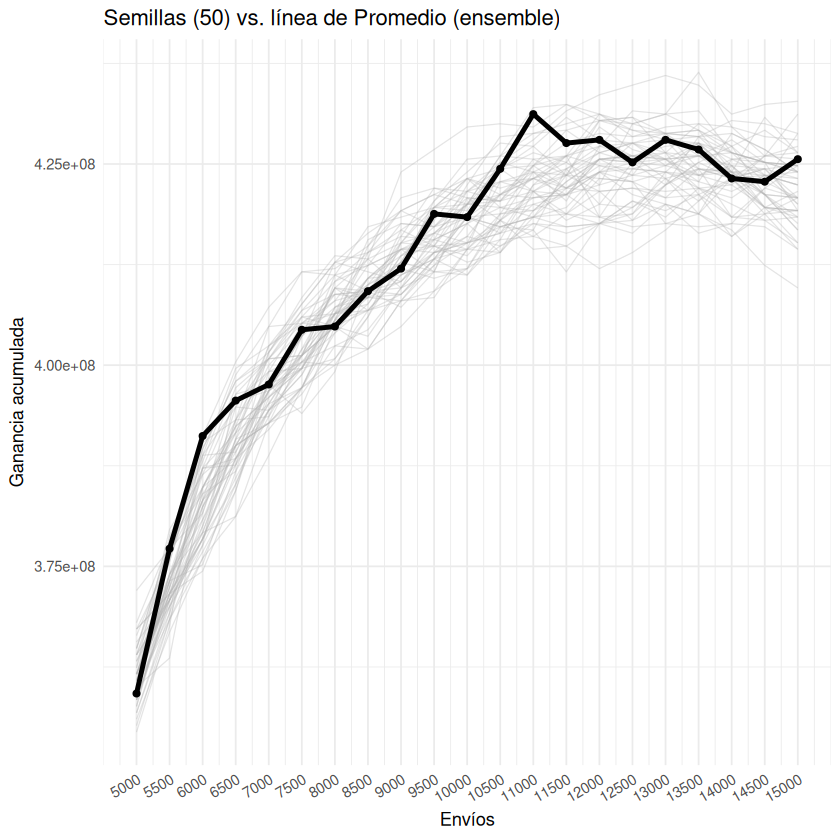

In [73]:
# plot semillas + ensemble
# marcamos el tipo de curva para estilizar el promedio
dt_semillas[, tipo := fifelse(semilla == "promedio",
                              "Ensemble promedio",
                              "Semilla individual")]

dt_seed <- dt_semillas[semilla != "promedio"]
dt_prom <- dt_semillas[semilla == "promedio"]

ggplot() +
  # semillas: gris, finas, semi-transparente
  geom_line(data = dt_seed,
            aes(x = envios, y = ganancia, group = semilla),
            color = "grey70", linewidth = 0.35, alpha = 0.35) +

  # promedio: negro, gruesa
  geom_line(data = dt_prom,
            aes(x = envios, y = ganancia),
            color = "black", linewidth = 1.4) +
  geom_point(data = dt_prom,
             aes(x = envios, y = ganancia),
             color = "black", size = 1.6) +
  labs(x = "Envíos", y = "Ganancia acumulada",
       title = paste0("Semillas (", length(semillas) ,") vs. línea de Promedio (ensemble)")) +
  scale_x_continuous(breaks = unique(dt_semillas$envios)) +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 30, hjust = 1)) 


### Clasificacion

Se tomó la decisión de enviar a los 11000 registros con mayor probabilidad de POS={"BAJA+1","BAJA+"}
<br> esto se determinó en forma artesanal analizando meses anterior
<br> esta es una muy importante decisión 

In [50]:
# genero archivos con los  "envios" mejores
dir.create("kaggle", showWarnings=FALSE)

tb_prediccion <- fread("prediccion.txt")

In [51]:
# genero archivos de fantasia, que NO son el que voy a subir a la Pseudo Competencia Kaggle
envios <- 11000

for( vapo in seq(PARAM$train_final$APO) ) {
  if( tb_prediccion[meta_modelo==vapo, .N] > 0 ) {
    tb_pred <- tb_prediccion[meta_modelo==vapo]
    setorder( tb_pred, -prob )
    tb_pred[, Predicted := 0L] # seteo inicial a 0
    tb_pred[1:envios, Predicted := 1L] # marco los primeros

    archivo_kaggle <- paste0("./kaggle/KA", PARAM$experimento, "_", vapo, "_", envios, ".csv")

    # grabo el archivo
    fwrite(tb_pred[, list(numero_de_cliente, Predicted)],
      file= archivo_kaggle,
      sep= ","
    )

    rm( tb_pred )
    gc()
  }
}

Sys.time()

[1] "2025-12-03 19:56:34 UTC"

### Subida a Pseudo Kaggle

### TODA ESTA PARTE NO APLICA PARA LA ENTREGA YA QUE DEPENDE DE TENER LA GANANCIA ####

Aqui viene la verdadera magia de  APO = A Prueba Overfiteres
<br>Se sube un submit a la Pseudo Competencia Kaggle cuya ganancia coincide casi exactamente con la ganancia MEDIA , promediada  APO veces

In [52]:
colmedias <- colMeans( mganancias, na.rm=TRUE )
mcorte_mejor <- max(colmedias, na.rm=TRUE)
icorte_mejor <- which.max( colmedias )
corte_mejor <- PARAM$train_final$cortes[icorte_mejor]

Warning message in max(colmedias, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


In [77]:
tbl <- as.data.table( as.list( colmedias ) )
colnames(tbl) <- paste0( "e", PARAM$train_final$cortes )
tbl[, experimento := PARAM$experimento ]

exp_gral <- "/content/buckets/b1/exp/apo-gral"
dir.create(exp_gral, showWarnings=FALSE)
fwrite( tbl,
  file= paste0( exp_gral, "/tb_experimentos.txt"),
  sep= "\t",
  append= TRUE
)

In [78]:
colnames( mganancias ) <- paste0( "e", PARAM$train_final$cortes )
tbl_local <- as.data.table( mganancias )

fwrite( tbl_local,
  file= "tb_apo.txt",
  sep= "\t"
)

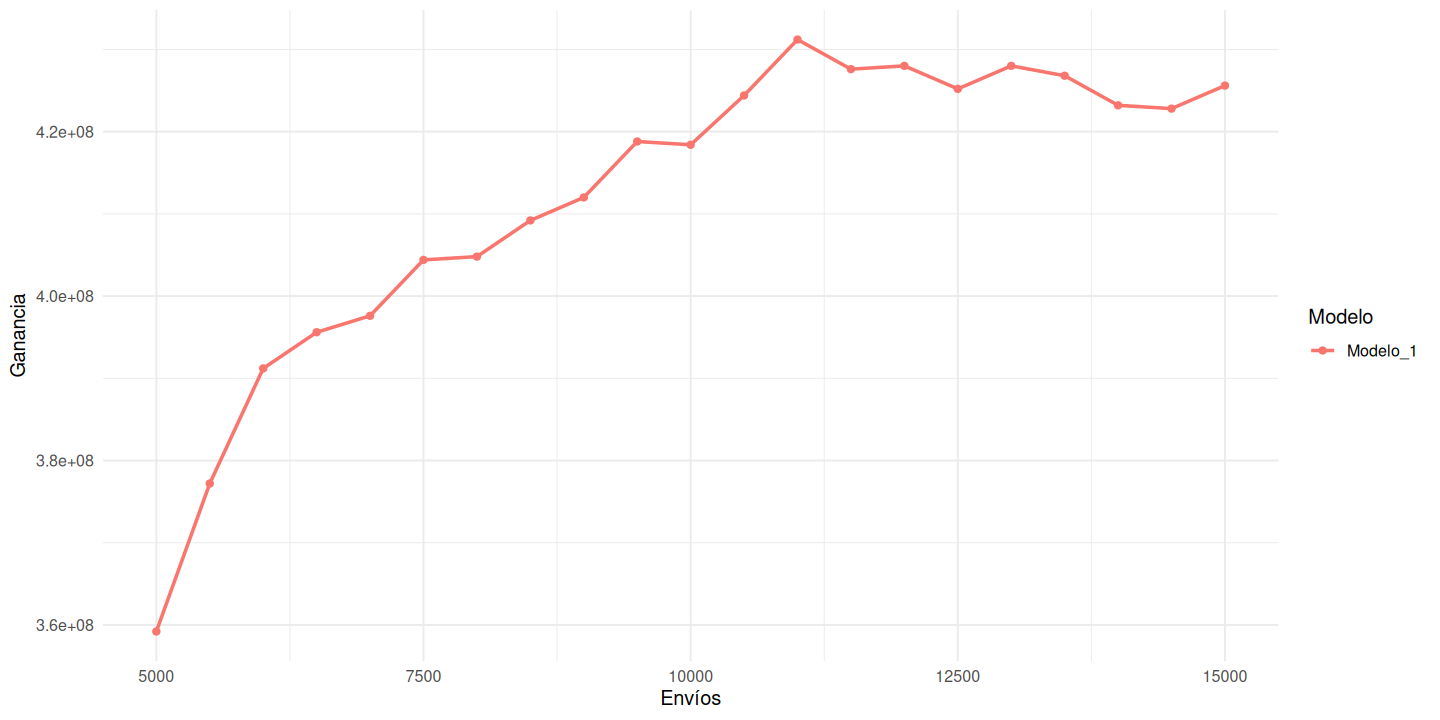

In [80]:
# Grafico las ganancias
library(ggplot2)
options(repr.plot.width = 12, repr.plot.height = 6)
# === 1) Usa tu data.table aquí ===
# Supongamos que se llama 'dt' y que TODAS sus columnas son cantidades de envíos (p.ej. "50","100","150")
# Si además tenés columnas extra (id, fecha, etc.), indicá cuáles son de envíos en 'cols_envios' manualmente.
dt <- as.data.table(mganancias)   # <- reemplazá por tu objeto

# Si ya tenés una columna con el nombre del modelo, usala en lugar de esto.
dt[, modelo := paste0("Modelo_", .I)]

# === 2) Identificar columnas de envíos ===
# Caso A: todas las columnas (excepto 'modelo') son de envíos:
cols_envios <- setdiff(names(dt), "modelo")

# (Opcional) Si tus nombres tienen prefijos tipo "envios_100", "k_050", etc.,
# igual los vamos a parsear más abajo.

# === 3) Ancho -> Largo ===
long <- melt(
  dt,
  id.vars = "modelo",
  measure.vars = cols_envios,
  variable.name = "envios_col",
  value.name = "ganancia"
)

# === 4) Extraer el número de envíos desde el nombre de columna ===
# - Si las columnas son "50","100","150": as.numeric(envios_col) alcanza.
# - Si tienen texto (p.ej. "envios_100"): usamos gsub para quedarnos con los dígitos.
long[, envios := suppressWarnings(as.numeric(as.character(envios_col)))]
idx_na <- is.na(long$envios)
if (any(idx_na)) {
  long[idx_na, envios := as.numeric(gsub("[^0-9\\.]+", "", envios_col))]
}

# Orden por modelo y envíos
setorder(long, modelo, envios)

# === 5) Plot: una curva por modelo ===
p <- ggplot(long, aes(x = envios, y = ganancia, color = modelo, group = modelo)) +
      geom_line(linewidth = 1) +
      geom_point() +
      labs(x = "Envíos", y = "Ganancia", color = "Modelo") +
      theme_minimal(base_size = 12)

print(p)

# Guardo el gif
ggsave("./grafico_ganancia.png", plot = p, width = 8, height = 5, dpi = 300)

In [81]:
icerca <- which.min(  abs( tb_prediccion$gan_acum - mcorte_mejor ) )
vmodelo <- tb_prediccion[ icerca, meta_modelo ]
tb_pred <- tb_prediccion[meta_modelo==vmodelo]

mcorte_mejor
icerca
tb_prediccion[ icerca]

[1] 431200000

[1] 10880

numero_de_cliente,foto_mes,meta_modelo,prob,gan_acum
<int>,<int>,<int>,<dbl>,<dbl>
1465724388,202107,1,0.1847209,431200000


In [82]:
icerca <- which.min(  abs( tb_pred$gan_acum - mcorte_mejor ) )
icerca

[1] 10880

In [83]:
icerca <- which.min(  abs( tb_prediccion$gan_acum - mcorte_mejor ) )
vmodelo <- tb_prediccion[ icerca, meta_modelo ]
tb_pred <- tb_prediccion[meta_modelo==vmodelo]

icerca <- which.min(  abs( tb_pred$gan_acum - mcorte_mejor ) )
tb_pred[, Predicted := 0L] # seteo inicial a 0
tb_pred[1:icerca, Predicted := 1L] # marco los primeros

archivo_pseudo_kaggle <- paste0("./kaggle/KA", PARAM$experimento, "_",  icerca, ".csv")

# grabo el archivo
fwrite(tb_pred[, list(numero_de_cliente, Predicted)],
  file= archivo_pseudo_kaggle,
  sep= ","
)


In [ ]:
# la subida a Kaggle
comando <- "kaggle competitions submit"
competencia <- "-c  test-202106"
arch <- paste( "-f", archivo_pseudo_kaggle)
mensaje <-  paste0( "-m 'exp=", PARAM$experimento,
  "  ", paste(names(plocal), plocal, sep= "=", collapse= ";" ),
  " envios=", icorte_mejor,"'")

                    
linea <- paste( comando, competencia, arch, mensaje)
salida <- system(linea, intern=TRUE)
cat(salida)

In [ ]:
Sys.time()